In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [81]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Loading Image

In [95]:
# Example: load one image
img_path = "/kaggle/input/bossbase/boss_256_0.4/cover/100.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # shape: (512, 512)

# Filters

In [84]:
# --- SRM Filter ---

#(3×3 kernels)
srm_filters = [
    np.array([[0, 0, 0], [0, 1, -1], [0, 0, 0]]),  # horizontal diff
    np.array([[0, 0, 0], [0, 1, 0], [0, -1, 0]]),  # vertical diff
    np.array([[1, -2, 1], [-2, 4, -2], [1, -2, 1]])  # laplacian-like
]

In [85]:
# --- Gabor Filter ---

def gabor_kernels(ksize=11):
    kernels = []
    for theta in np.arange(0, np.pi, np.pi / 4):  # 0,45,90,135 degrees
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kernels.append(kern)
    return kernels

gabor_kerns = gabor_kernels()

# RAN

In [86]:
class ResidualAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ResidualAttention, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, h, w = x.size()
        y = self.global_pool(x).view(b, c)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Creating Batches

In [87]:
# --- BOSSBase Dataset ---
class BossBaseDataset(Dataset):
    def __init__(self, cover_dir, stego_dir=None, transform=None):
        """
        cover_dir: path to cover images
        stego_dir: path to stego images (optional)
        transform: torchvision transforms (resize, normalization, etc.)
        """
        self.cover_files = sorted([os.path.join(cover_dir, f) for f in os.listdir(cover_dir) if f.endswith(".png")])
        self.stego_files = []
        if stego_dir:
            self.stego_files = sorted([os.path.join(stego_dir, f) for f in os.listdir(stego_dir) if f.endswith(".png")])
        self.transform = transform
        self.att_module = None  # will be initialized later

        # Define SRM filters
        self.srm_filters = [
            np.array([[0, 0, 0], [0, 1, -1], [0, 0, 0]]),
            np.array([[0, 0, 0], [0, 1, 0], [0, -1, 0]]),
            np.array([[1, -2, 1], [-2, 4, -2], [1, -2, 1]])
        ]
        
        self.gabor_kerns = gabor_kernels()

    def __len__(self):
        return len(self.cover_files) + len(self.stego_files)

    def __getitem__(self, idx):
        if idx < len(self.cover_files):
            img_path = self.cover_files[idx]
            label = 0  # cover
        else:
            img_path = self.stego_files[idx - len(self.cover_files)]
            label = 1  # stego

        # Load grayscale + RGB version
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        global residual_maps
        residual_maps = []
        for f in self.srm_filters:
            res = cv2.filter2D(img.astype(np.float32), -1, f)
            residual_maps.append(res)
        residual_maps = np.stack(residual_maps, axis=-1)  # (H, W, Cr)

        # --- Gabor Maps ---
        global gabor_maps
        gabor_maps = []
        for k in self.gabor_kerns:
            filtered = cv2.filter2D(img, cv2.CV_32F, k)
            gabor_maps.append(filtered)
        gabor_maps = np.stack(gabor_maps, axis=-1)  # (H, W, Cg)

        # --- Convert to torch tensors ---
        residual_tensor = torch.tensor(residual_maps.transpose(2, 0, 1)).unsqueeze(0).float()  # (1, Cr, H, W)
        gabor_tensor = torch.tensor(gabor_maps.transpose(2, 0, 1)).unsqueeze(0).float()        # (1, Cg, H, W)
        rgb_tensor = torch.tensor(img_rgb.transpose(2, 0, 1)).unsqueeze(0).float()            # (1, 3, H, W)

        fused_input = torch.cat([residual_tensor, gabor_tensor, rgb_tensor], dim=1).squeeze(0)

        if self.transform:
            fused_input = self.transform(fused_input)

        return fused_input, torch.tensor(label, dtype=torch.long)

In [89]:
from torch.utils.data import DataLoader

cover_dir = "/kaggle/input/bossbase/boss_256_0.4/cover"
stego_dir = "/kaggle/input/bossbase/boss_256_0.4/stego"

dataset = BossBaseDataset(cover_dir, stego_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

cnt = 0

ran = ResidualAttention(channels=dataset[0][0].shape[0]) 

for batch in dataloader:
    fused_input, labels = batch
    attended_features = ran(fused_input)  
    print("Attended features:", attended_features.shape)

    break

Attended features: torch.Size([4, 10, 256, 256])


(B,C,H,W)
**B = BATCH
C = CHANNELS
H = Height
W = Width**


In [96]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # (512,512,3)
img_ycbcr = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2YCrCb)

In [92]:
combined_input = np.concatenate([residual_maps, gabor_maps, img_rgb], axis=-1)
print(combined_input.shape)  # (512, 512, K1+K2+3)

(256, 256, 10)


# Visualizing the Filters

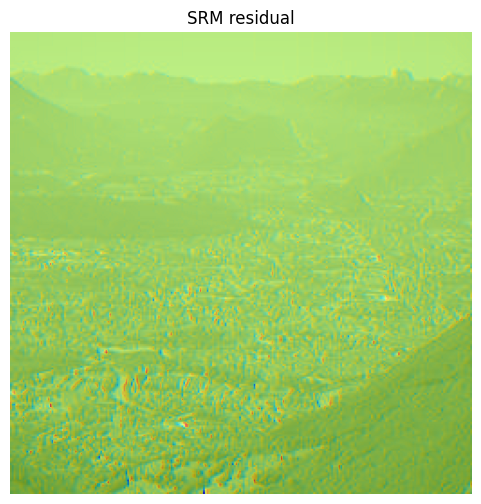

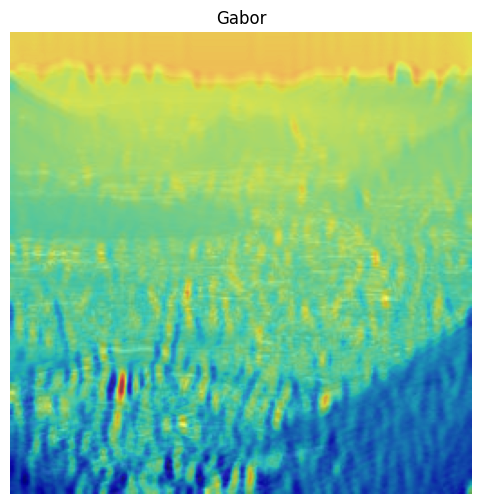

In [97]:
def extract_features(img, srm_filters, gabor_kerns):
    residual_maps = [cv2.filter2D(img.astype(np.float32), -1, f) for f in srm_filters]
    gabor_maps = [cv2.filter2D(img, cv2.CV_32F, k) for k in gabor_kerns]
    return np.stack(residual_maps, axis=-1), np.stack(gabor_maps, axis=-1)


residual_maps, gabor_maps = extract_features(img, srm_filters, gabor_kerns)

# ---- Example usage ----
residual_maps, gabor_maps = extract_features(img, srm_filters, gabor_kerns)
overlay_heatmap(img, residual_maps[..., 0], title="SRM residual")
overlay_heatmap(img, gabor_maps[..., 0], title="Gabor")

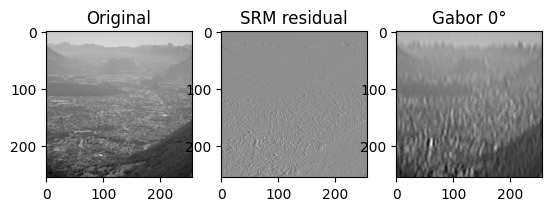

In [99]:
# visualize original
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")

# visualize one SRM residual
plt.subplot(1, 3, 2)
plt.imshow(residual_maps[..., 0], cmap='gray')
plt.title("SRM residual")

# visualize one Gabor map
plt.subplot(1, 3, 3)
plt.imshow(gabor_maps[..., 0], cmap='gray')
plt.title("Gabor 0°")
plt.show()


In [100]:
import torch

# Example: combine residual + gabor maps only (leave RGB separate for now)
residual_features = np.concatenate([residual_maps, gabor_maps], axis=-1)  # (H, W, Cr+Cg)

# Convert to torch tensor (N, C, H, W)
residual_tensor = torch.tensor(residual_features.transpose(2, 0, 1)).unsqueeze(0).float()  # (1, C, H, W)

# Apply attention
att_module = ResidualAttention(channels=residual_tensor.size(1))
attended_residuals = att_module(residual_tensor)  # (1, C, H, W)

print("Attended residuals shape:", attended_residuals.shape)

Attended residuals shape: torch.Size([1, 7, 256, 256])


In [101]:
# Prepare RGB as torch tensor (1, 3, H, W)
rgb_tensor = torch.tensor(img_rgb.transpose(2, 0, 1)).unsqueeze(0).float()

# Fuse them
fused_input = torch.cat([attended_residuals, rgb_tensor], dim=1)  # (1, C_total, H, W)

print("Fused input shape:", fused_input.shape)

Fused input shape: torch.Size([1, 10, 256, 256])
